In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from IPython.display import display
pd.options.display.precision = 15
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# google!
# base_path = '/content/drive/MyDrive/Colab Notebooks/미니프로젝트_모델링/data/'

base_path = '../../data/'

train_id = pd.read_csv(base_path + 'train_identity.csv')
train_trans = pd.read_csv(base_path + 'train_transaction.csv')
test_id = pd.read_csv(base_path + 'test_identity.csv')
test_trans = pd.read_csv(base_path + 'test_transaction.csv')
submission = pd.read_csv(base_path + 'sample_submission.csv')

# CHK
# display(train_id.head())
# display(train_trans.head())
# display(test_id.head())
# display(test_trans.head())

In [6]:
# column명 변경
test_id.columns = [i.replace('-','_') for i in test_id.columns]
# test_id

In [7]:
# 전체 데이터셋 합
train = train_trans.merge(train_id, how='left', on='TransactionID')
test = test_trans.merge(test_id, how='left', on='TransactionID')

# CHK
# display(train.head())
# display(test.head())

In [8]:
# 메모리 필요시 삭제
# del train_id, train_trans, test_id, test_trans

In [9]:
## Dataframe size reduction
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## memory reduction
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


- https://www.kaggle.com/code/khyj00/ieee-cis-fraud-detection/notebook?scriptVersionId=74419082
- https://www.kaggle.com/code/kimjihoo/all-in-one-for-ieee-cis-fraud-detection-korean/notebook
- https://eda-ai-lab.tistory.com/448
- https://slowsteadystat.tistory.com/19

## Comments from Vesta: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

### 1. train_identity - 식별 정보 테이블
 - 거래와 관련된 식별 정보
    >1. 네트워크 연결 정보 (IP, ISP, Proxy 등등)  
    >
    >2. 디지털 서명 정보 (UA/browser/os/version 등등)

 - Vesta사의 사기 방지 시스템 및 디지털 보안 협력업체에서 수집  

 - 개인 정보 보호 및 계약 동의로 인해 상세한 내용은 제공되지 않음  
 
 - 범주형 변수: DeviceType, DeviceInfo, id12 - id38  

- Categorical Features of Identity Table:
    > - DeviceType
    > - DeviceInfo
    > - id_12 - id_38

### 2. train_transaction - 거래 정보 테이블
- TransactionDT: 주어진 reference datetime으로부터의 timedelta 값 (실제 timestamp가 아님)  
    > timedelta 값이란? date, time 또는 datetime 인스턴스 간의 차이, 초단위

- TransactionAMT: 결제 금액 (단위: 달러)
- ProductCD: 제품 코드 (범주형 변수)
- card1 - card6: 결제 카드 정보 (예를 들어, 카드 유형, 발행 은행, 국가 등등) (범주형 변수)
- addr: 주소 (범주형 변수)
- dist: 거리
- P_ and (R__) emaildomain: 구매자와 수취인의 이메일 도메인 (범주형 변수)
- C1-C14: 카운팅 정보 (예를 들어, 결제 카드와 관련 있는 주소의 수 등등) -> 실제 의미는 숨겨져 있음
- D1-D15: timedelta 값 (예를 들어, 이전 거래한 날짜와의 차이)
- M1-M9: 일치 정보 - Matched(예를 들어, 카드에 적힌 이름 일치하는지, 주소가 일치하는지 등등) (범주형 변수)
- Vxxx: Vesta사에서 만들어낸 변수 (랭킹, 카운팅, 관계 등등)  

- Categorical Features of Transaction Table:
    > - ProductCD
    > - card1 - card6
    > - addr1, addr2
    > - P_emaildomain
    > - R_emaildomain
    > - M1 - M9

### The list of columns without the missingness (결측치가 없는 컬럼 리스트)
- isFraud  

- TransactionAmt  

- ProductCD  

- card1  

- C1~C14  

### Discussions and Topics: https://www.kaggle.com/linwangatvesta/discussion?sortBy=mostVotes&group=commentsAndTopics&page=1&pageSize=20

- We define reported chargeback on card, user account, associated email address and transactions directly linked to these attributes as fraud transaction (isFraud=1); If none of above is found after 120 days, then we define as legit (isFraud=0)
    > 카드, 사용자 계정, 관련 이메일 주소 및 이러한 속성에 직접 연결된 거래에 대해 보고된 지불 거절을 사기 거래(isFraud=1)로 정의합니다. 120일 후에도 위의 항목이 발견되지 않으면 합법적인 것으로 정의합니다(isFraud=0).
- These payments are from different countries, including North America, Latin America, Europe. But TransactionAmt has been converted to USD. 
    > 금액은 모두 달러로 환산
- addr1 as billing zipcode(region) addr2 as billing country. 
    > addr1은 우편번호(지역), addr2는 국가  
- dist: distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.
    > 무언지 모르는 두 지점 간 거리
- All variables marked as categorical are unordered. There're some of boolean variables marked as categorical too.
The remaining variables are having numerical characteristics **(one of which is the ordering matters)**. Your observation is correct - there're some numerical variables are having limited values. For example, how many email address are linked to a payment card; the count is an integer, which you can treat as either numerical or categorical; However, **ordering of that indeed indicates risk level**. 
    > 범주형 데이터 중 하나는 번호 순서가 리스크 레벨을 나타내는데 매우 주요함
- TransactionID in transaction table and identity (for both train and test dataset) are not necessary matched. Some transaction has identity information, else don't. If you join the two tables correctly, you'll find many missing values in identity columns, which is a challenge in our fraud detection. 
    > 조인 잘하면 널값 채울 수 있다.
- Regarding ProductCD, you may understand it as we sell several different product (Product W, C, R, H, S) and each product has its own fraud rate. When we build and evaluate models, we'll try different perspectives, not only the entire volume of transactions, but also in segmentation. In other words, we try hard to do best in all products. 
    > 상품에 따라 이상 발생 확률이 다르다.
- A card contains many information, including card category (credit, debit), card type (visa, mastercard, discover, etc), issue bank (Chase, Citi, etc) and issue country, etc. We encoded the real values due to data privacy. 
    > card는 카드종류, 카드사, 발행은행, 발행국가, (초기 번호 몇 자리) 등 인코딩 한 값
- P-Purchaser; R-Recipient 
    > P-구매자; R-판매자
- Yes, all transactions linked to the same payment card which is identified as fraudulent will be labeled as fraud. However, exact card information is NOT included in the dataset. 
    > 이상 카드로 판명되면 관련 결제건은 모두 이상 거래
-  TransactionID is unique identification number (UID), it's used to join the two tables. It won't and shouldn't appear more than once. 
    > TransactionID는 고유값(UID)이며, 테이블 조인할 때 사용









In [10]:
import scipy as sp
from scipy import stats

# datatype and shape CHK
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [11]:
train_rst = resumetable(train)
train_rst[:5]

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.170000000000002
1,isFraud,int8,0,2,0,0,0,0.220000000000000
2,TransactionDT,int32,0,573349,86400,86401,86469,19.109999999999999
3,TransactionAmt,float16,0,8195,68.5,29.0,59.0,8.100000000000000
4,ProductCD,object,0,5,W,W,W,1.280000000000000


In [12]:
train.columns[train.nunique() == 2]

Index(['isFraud', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V14',
       'V41', 'V65', 'V88', 'V107', 'V305', 'id_12', 'id_16', 'id_27', 'id_28',
       'id_29', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType'],
      dtype='object')

In [13]:
train[train.columns[train.nunique() == 2]].head()

,isFraud,M1,M2,M3,M5,M6,M7,M8,M9,V1,V14,V41,V65,V88,V107,V305,id_12,id_16,id_27,id_28,id_29,id_35,id_36,id_37,id_38,DeviceType
0,0,T,T,T,F,T,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,T,T,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,T,T,T,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,NaN,NaN,NaN,T,F,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NotFound,NotFound,NaN,New,NotFound,T,F,T,T,mobile


In [14]:
test.columns[test.nunique() == 1]

Index(['V107'], dtype='object')

In [15]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [78]:
train_rst[train_rst['dtypes']=='object']

,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
4,ProductCD,object,0,5,W,W,W,1.28
8,card4,object,1577,4,discover,mastercard,visa,1.09
10,card6,object,1571,4,credit,credit,debit,0.82
15,P_emaildomain,object,94456,59,NaN,gmail.com,outlook.com,2.68
16,R_emaildomain,object,453249,60,NaN,NaN,NaN,2.76
46,M1,object,271100,2,T,NaN,T,0.00
47,M2,object,271100,2,T,NaN,T,0.49
48,M3,object,271100,2,T,NaN,T,0.75
49,M4,object,281444,3,M2,M0,M0,1.31
50,M5,object,350482,2,F,T,F,0.99


In [16]:
# Target Columns
feature_columns = train.loc[:,'isFraud']

In [17]:
train_m = train.iloc[:,46:55]
train_m.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
train_m_chk = pd.concat([feature_columns, train_m], axis=1)
train_m_chk.head()

,isFraud,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,0,T,T,T,M2,F,T,NaN,NaN,NaN
1,0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,0,T,T,T,M0,F,F,F,F,F
3,0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
resumetable(train_m_chk)

Dataset Shape: (590540, 10)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,isFraud,int8,0,2,0,0,0,0.22
1,M1,object,271100,2,T,NaN,T,0.00
2,M2,object,271100,2,T,NaN,T,0.49
3,M3,object,271100,2,T,NaN,T,0.75
4,M4,object,281444,3,M2,M0,M0,1.31
5,M5,object,350482,2,F,T,F,0.99
6,M6,object,169360,2,T,T,F,1.00
7,M7,object,346265,2,NaN,NaN,F,0.57
8,M8,object,346252,2,NaN,NaN,F,0.95
9,M9,object,346252,2,NaN,NaN,F,0.63


In [20]:
train_m_chk[train_m_chk['isFraud'] == 1].shape

(20663, 10)

In [21]:
# M 전체 행 NaN 없는 경우 출력
train_m_chk_dropna = train_m_chk.dropna()
train_m_chk_dropna.shape

(122027, 10)

In [22]:
# 같은것
# '''
# train_m_nona = train_m_chk[(train_m_chk['M1'].notnull()) 
#         & (train_m_chk['M2'].notnull()) 
#         & (train_m_chk['M3'].notnull()) 
#         & (train_m_chk['M4'].notnull()) 
#         & (train_m_chk['M5'].notnull()) 
#         & (train_m_chk['M6'].notnull()) 
#         & (train_m_chk['M7'].notnull()) 
#         & (train_m_chk['M8'].notnull())
#         & (train_m_chk['M9'].notnull())]

# train_m_nona
# '''

In [23]:
train_m.shape

(590540, 9)

In [24]:
# M 모든값이 NaN 행 제외하고 출력
train_m_chk_dropna_all = train_m_chk.dropna(how="all")
train_m_chk_dropna_all.shape
# 모든 값이 NaN인 행은 없음

(590540, 10)

In [25]:
train_m_chk_frd = train_m_chk_dropna[train_m_chk_dropna['isFraud'] == 1]
resumetable(train_m_chk_frd.reset_index())

# isFraud=True 중 모든 Mn 값에 대해 NaN이 없는 행 확인... 총 3899행

Dataset Shape: (3899, 11)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,index,int64,0,3899,1081,1992,2357,11.93
1,isFraud,int8,0,1,1,1,1,0.00
2,M1,object,0,1,T,T,T,0.00
3,M2,object,0,2,F,T,T,0.71
4,M3,object,0,2,F,T,T,0.90
5,M4,object,0,3,M0,M0,M0,0.88
6,M5,object,0,2,F,F,F,1.00
7,M6,object,0,2,F,T,F,0.97
8,M7,object,0,2,F,T,F,0.62
9,M8,object,0,2,F,T,F,0.88


In [26]:
# multi columns encoding

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

class MultiColLabelEncoder:
    def __init__(self):
        self.encoder_dict = defaultdict(LabelEncoder)
        
    def fit_transform(self, X: pd.DataFrame, columns: list): # 컬럼명 리스트 기준으로 레이블인코딩
        if not isinstance(columns, list):
            columns = [columns]
        
        output = X.copy()
        output[columns] = X[columns].apply(lambda x: self.encoder_dict[x.name].fit_transform(x))
        
        return output
    
    def inverse_transform(self, X: pd.DataFrame, columns: list): # 인코딩 된 열 레이블 복구
        if not isinstance(columns, list):
            columns = [columns]
            
        if not all(key in self.encoder_dict for key in columns):
            raise KeyError(f'At least one of {columns} is not encoded before')
            
        output = X.copy()
        try:
            output[columns] = X[columns].apply(lambda x: self.encoder_dict[x.name].inverse_transform(x))
        except ValueError:
            print(f'Need assignment when do "fit_transform" function')
            raise
            
        return output

In [27]:
# encoding
list_obj_trans = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
train_m_chk_encoded = MultiColLabelEncoder().fit_transform(train_m_chk, columns=list_obj_trans)

# Check
display(train_m_chk_encoded.tail(10))
display(train_m_chk.tail(10))

,isFraud,M1,M2,M3,M4,M5,M6,M7,M8,M9
590530,0,2,2,2,3,2,1,2,2,2
590531,0,2,2,2,3,2,2,2,2,2
590532,0,1,1,1,3,2,1,0,0,1
590533,0,1,1,1,3,2,0,0,0,1
590534,0,2,2,2,2,2,2,2,2,2
590535,0,1,1,1,0,1,0,0,0,1
590536,0,1,0,0,0,0,1,0,0,0
590537,0,1,0,0,3,2,1,2,2,2
590538,0,1,1,1,0,0,1,2,2,2
590539,0,1,0,0,3,2,1,0,0,0


,isFraud,M1,M2,M3,M4,M5,M6,M7,M8,M9
590530,0,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN
590531,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590532,0,T,T,T,NaN,NaN,T,F,F,T
590533,0,T,T,T,NaN,NaN,F,F,F,T
590534,0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
590535,0,T,T,T,M0,T,F,F,F,T
590536,0,T,F,F,M0,F,T,F,F,F
590537,0,T,F,F,NaN,NaN,T,NaN,NaN,NaN
590538,0,T,T,T,M0,F,T,NaN,NaN,NaN
590539,0,T,F,F,NaN,NaN,T,F,F,F


In [28]:
train_m_chk_encoded.describe()

,isFraud,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000,590540.000000000000000
mean,0.034990009144173,1.459029024282860,1.401544349239679,1.344415280929319,1.721962949165171,1.369138415687337,0.900944897890067,1.228419751413960,1.323434483692891,1.520913062620652
std,0.183754634178414,0.498403920591945,0.596121719907638,0.674615683800631,1.348733276170734,0.825583277969679,0.814138217773955,0.944517079250443,0.862913217566456,0.616765329601846
min,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000
25%,0.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,0.000000000000000,1.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,1.000000000000000
50%,0.000000000000000,1.000000000000000,1.000000000000000,1.000000000000000,2.000000000000000,2.000000000000000,1.000000000000000,2.000000000000000,2.000000000000000,2.000000000000000
75%,0.000000000000000,2.000000000000000,2.000000000000000,2.000000000000000,3.000000000000000,2.000000000000000,2.000000000000000,2.000000000000000,2.000000000000000,2.000000000000000
max,1.000000000000000,2.000000000000000,2.000000000000000,2.000000000000000,3.000000000000000,2.000000000000000,2.000000000000000,2.000000000000000,2.000000000000000,2.000000000000000


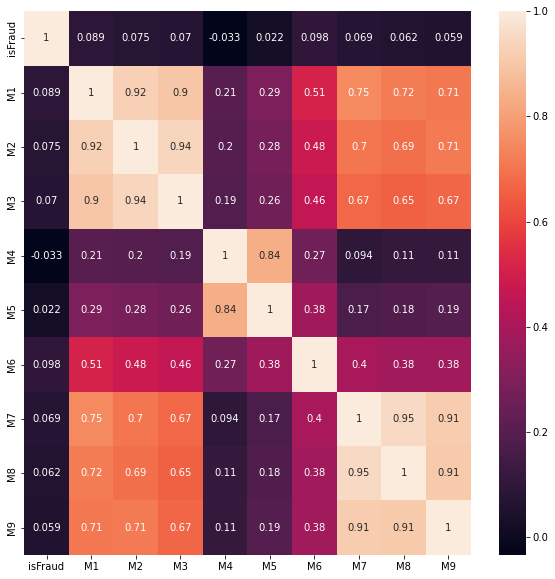

In [29]:
# Mn 상관관계 확인
plt.figure(figsize=(10,10))
sns.heatmap(train_m_chk_encoded.corr(), annot=True)
plt.show()

## Mn 컬럼내 변수들은 isFraud 와 확연하게 눈에 띄는 상관관계는 없음...

- 시각화 결과 오히려 (M1, M2, M3) 와 (M4, M5) 그리고 (M7, M8, M9)가 서로 상관관계가 높은 것으로 보임
- 따로노는것 같은 M6의 경우 모든 Mn 컬럼들 중 isFraud와 가장 큰 상관관계를 갖음으로 그냥 버리기도 애매함
- 결국 인코딩하여 결측치 없앤 후 모든 컬럼 사용하는게 좋을것으로 사료됨

In [30]:
# import models
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.6/120.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 12.4 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for pyod: filename=pyod-1.0.1-py3-none-any.whl size=147454 sha256=29295e30bdd0288b6de433e0bc50a3683036f35a91b4fbbc4588654561836fff
  Stored in directory: /Users/krc/Library/Caches/pip/wheels/b1/cc/4c/627210c240d68c4932857dd69725a40032b429dd967323314a
Successfully built pyod


In [31]:
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.pca import PCA
from pyod.models.iforest import IForest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [46]:
# encoding
list_obj_trans = list(train_rst[train_rst['dtypes'] == 'object']['Name'])
train_encoded = MultiColLabelEncoder().fit_transform(train, columns=list_obj_trans)

# NaN 처리 => -9999
train_encoded_fna = train_encoded.fillna(-999.9)

In [47]:
# 우선 생으로 돌려보기
X_train = train_encoded_fna.drop(columns=['isFraud'])
y_train = train_encoded_fna[['isFraud']]

# X_train = train_m_chk_encoded.drop(columns=['isFruad'])
# y_train = train_m_chk_encoded[['isFraud']]

# # standardize
# scaler = MinMaxScaler(feature_range=(0,1))
# X_train[['Amount']] = scaler.fit_transform(X_train[['Amount']])

In [48]:
# setting parameters
random_state = np.random.RandomState(0xC0FFEE)
outliers_fraction = 0.0035
# Define seven outlier detection tools to be compared
classifiers = {
        'LOF': LOF(contamination=outliers_fraction),
        'HBOS': HBOS(contamination=outliers_fraction),
        'PCA': PCA(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
}

# model fitting
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X_train)
    y_pred = clf.labels_
    print(clf_name)
    print('accuracy : ',round(accuracy_score(y_train,y_pred),3))
    print('precision : ',round(precision_score(y_train,y_pred),3))
    print('recall : ',round(recall_score(y_train,y_pred),3))
    print('f1 : ',round(f1_score(y_train,y_pred),3))
    print('-------------------')

LOF
accuracy :  0.962
precision :  0.083
recall :  0.008
f1 :  0.015
-------------------
HBOS
accuracy :  0.962
precision :  0.054
recall :  0.005
f1 :  0.01
-------------------
PCA
accuracy :  0.962
precision :  0.042
recall :  0.004
f1 :  0.008
-------------------
Isolation Forest
accuracy :  0.962
precision :  0.032
recall :  0.003
f1 :  0.006
-------------------


In [98]:
train_card = train_encoded.iloc[:,5:11]
train_card_frd = pd.concat([train_encoded.loc[:,'isFraud'],train_card], axis=1)

train_others = pd.concat([train_encoded.iloc[:,2:5], train_encoded.iloc[:,11:17]], axis=1)
train_others_frd = pd.concat([train_encoded.loc[:,'isFraud'],train_others], axis=1)

train_c = train_encoded.iloc[:,17:31]
train_c_frd = pd.concat([train_encoded.loc[:,'isFraud'],train_c], axis=1)

train_d = train_encoded.iloc[:,31:46]
train_d_frd = pd.concat([train_encoded.loc[:,'isFraud'],train_d], axis=1)

train_v = train_encoded.iloc[:,55:394]
train_v_frd = pd.concat([train_encoded.loc[:,'isFraud'],train_v], axis=1)

train_id = train_encoded.iloc[:,394:]
train_id_frd = pd.concat([train_encoded.loc[:,'isFraud'],train_id], axis=1)

In [102]:
resumetable(train_card)
resumetable(train_others)
resumetable(train_c)
resumetable(train_d)
resumetable(train_v)
resumetable(train_id)

Dataset Shape: (590540, 6)
Dataset Shape: (590540, 9)
Dataset Shape: (590540, 14)
Dataset Shape: (590540, 15)
Dataset Shape: (590540, 339)
Dataset Shape: (590540, 40)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id_01,float16,446307,77,NaN,NaN,NaN,2.270000000000000
1,id_02,float32,449668,115655,NaN,NaN,NaN,16.719999999999999
2,id_03,float16,524216,24,NaN,NaN,NaN,0.320000000000000
3,id_04,float16,524216,15,NaN,NaN,NaN,0.100000000000000
4,id_05,float16,453675,93,NaN,NaN,NaN,2.400000000000000
5,id_06,float16,453675,101,NaN,NaN,NaN,2.630000000000000
6,id_07,float16,585385,84,NaN,NaN,NaN,5.390000000000000
7,id_08,float16,585385,94,NaN,NaN,NaN,5.720000000000000
8,id_09,float16,515614,46,NaN,NaN,NaN,0.510000000000000
9,id_10,float16,515614,62,NaN,NaN,NaN,0.300000000000000


In [103]:
train_card_frd_fn = train_card_frd.fillna(train_card_frd.median())

train_others_frd_fn = train_others_frd.fillna(train_others_frd.median())

train_c_frd_fn = train_c_frd.fillna(train_c_frd.median())

train_d_frd_fn = train_d_frd.fillna(train_d_frd.median())

train_v_frd_fn = train_v_frd.fillna(train_v_frd.median())

train_id_frd_fn = train_id_frd.fillna(train_id_frd.median())

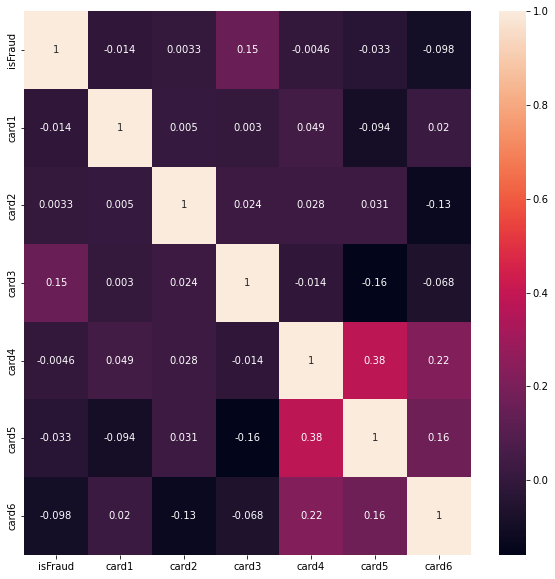

In [106]:
# 전체 상관관계 확인
plt.figure(figsize=(10,10))
sns.heatmap(train_card_frd_fn.corr(), annot=True)
plt.show()

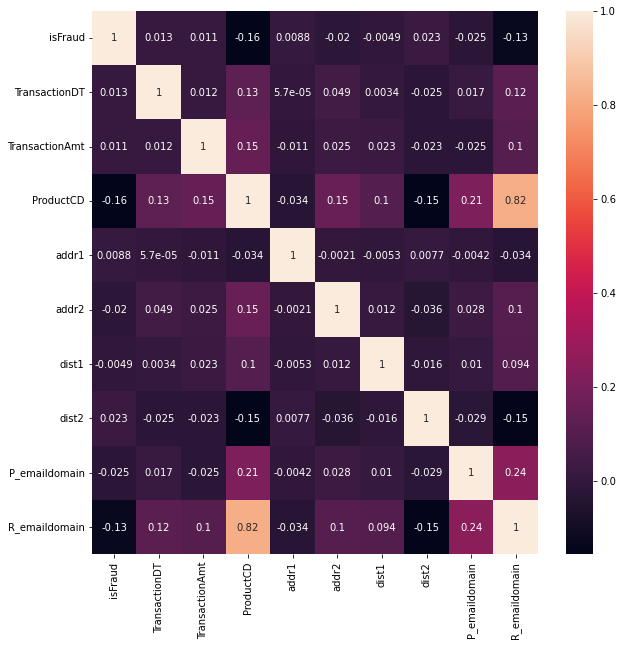

In [107]:
plt.figure(figsize=(10,10))
sns.heatmap(train_others_frd_fn.corr(), annot=True)
plt.show()

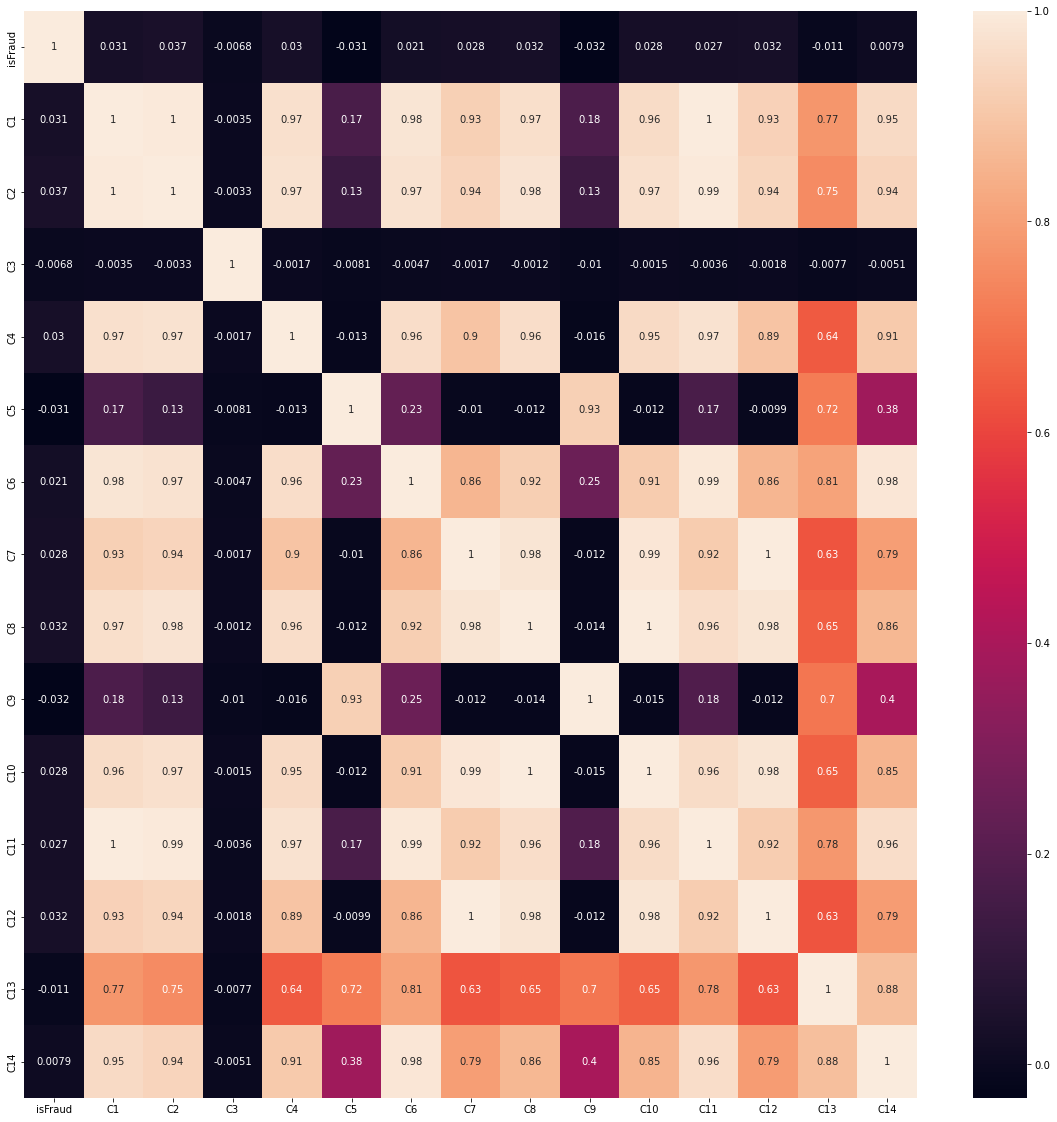

In [109]:
plt.figure(figsize=(20,20))
sns.heatmap(train_c_frd_fn.corr(), annot=True)
plt.show()

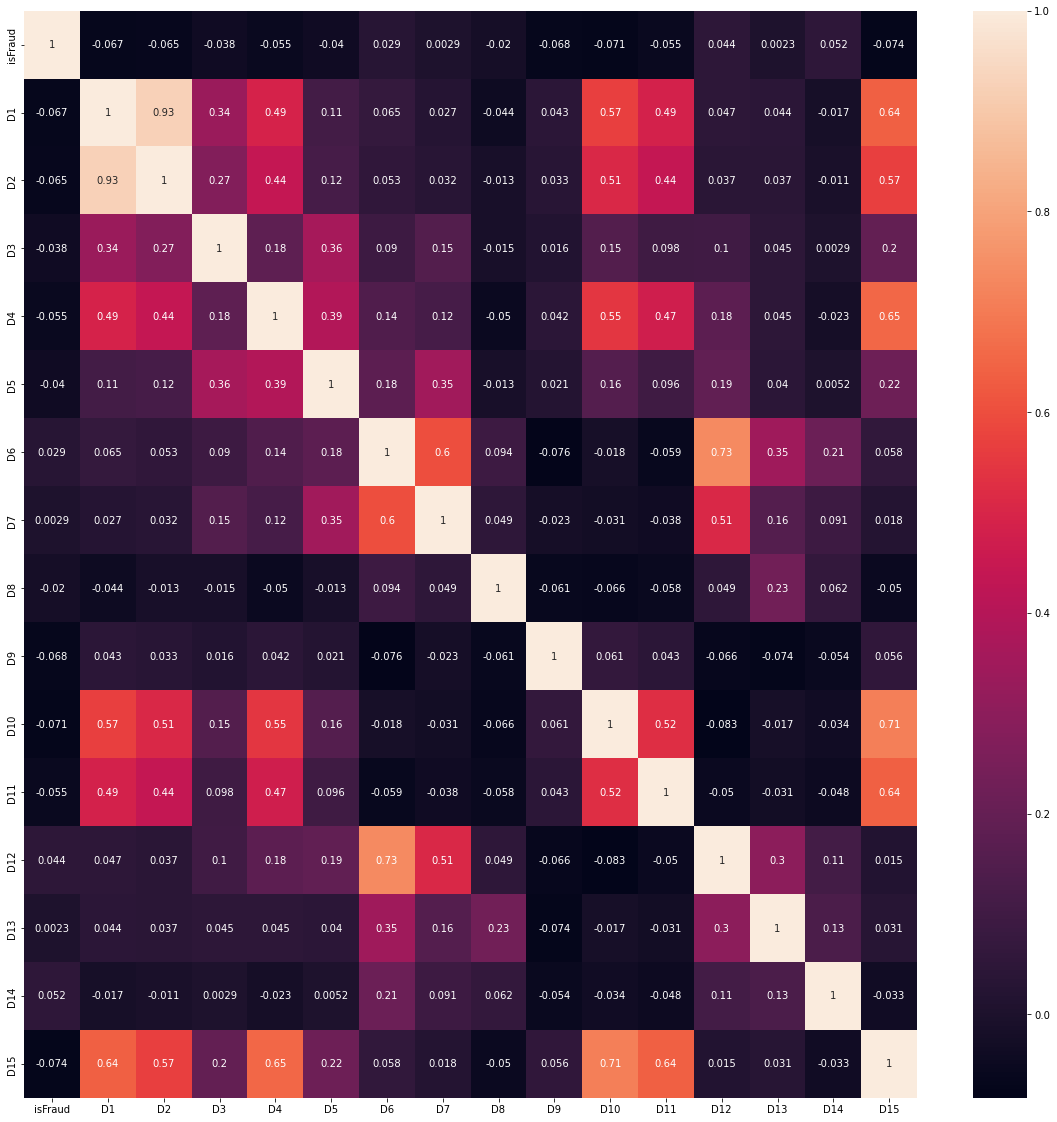

In [111]:
plt.figure(figsize=(20,20))
sns.heatmap(train_d_frd_fn.corr(), annot=True)
plt.show()

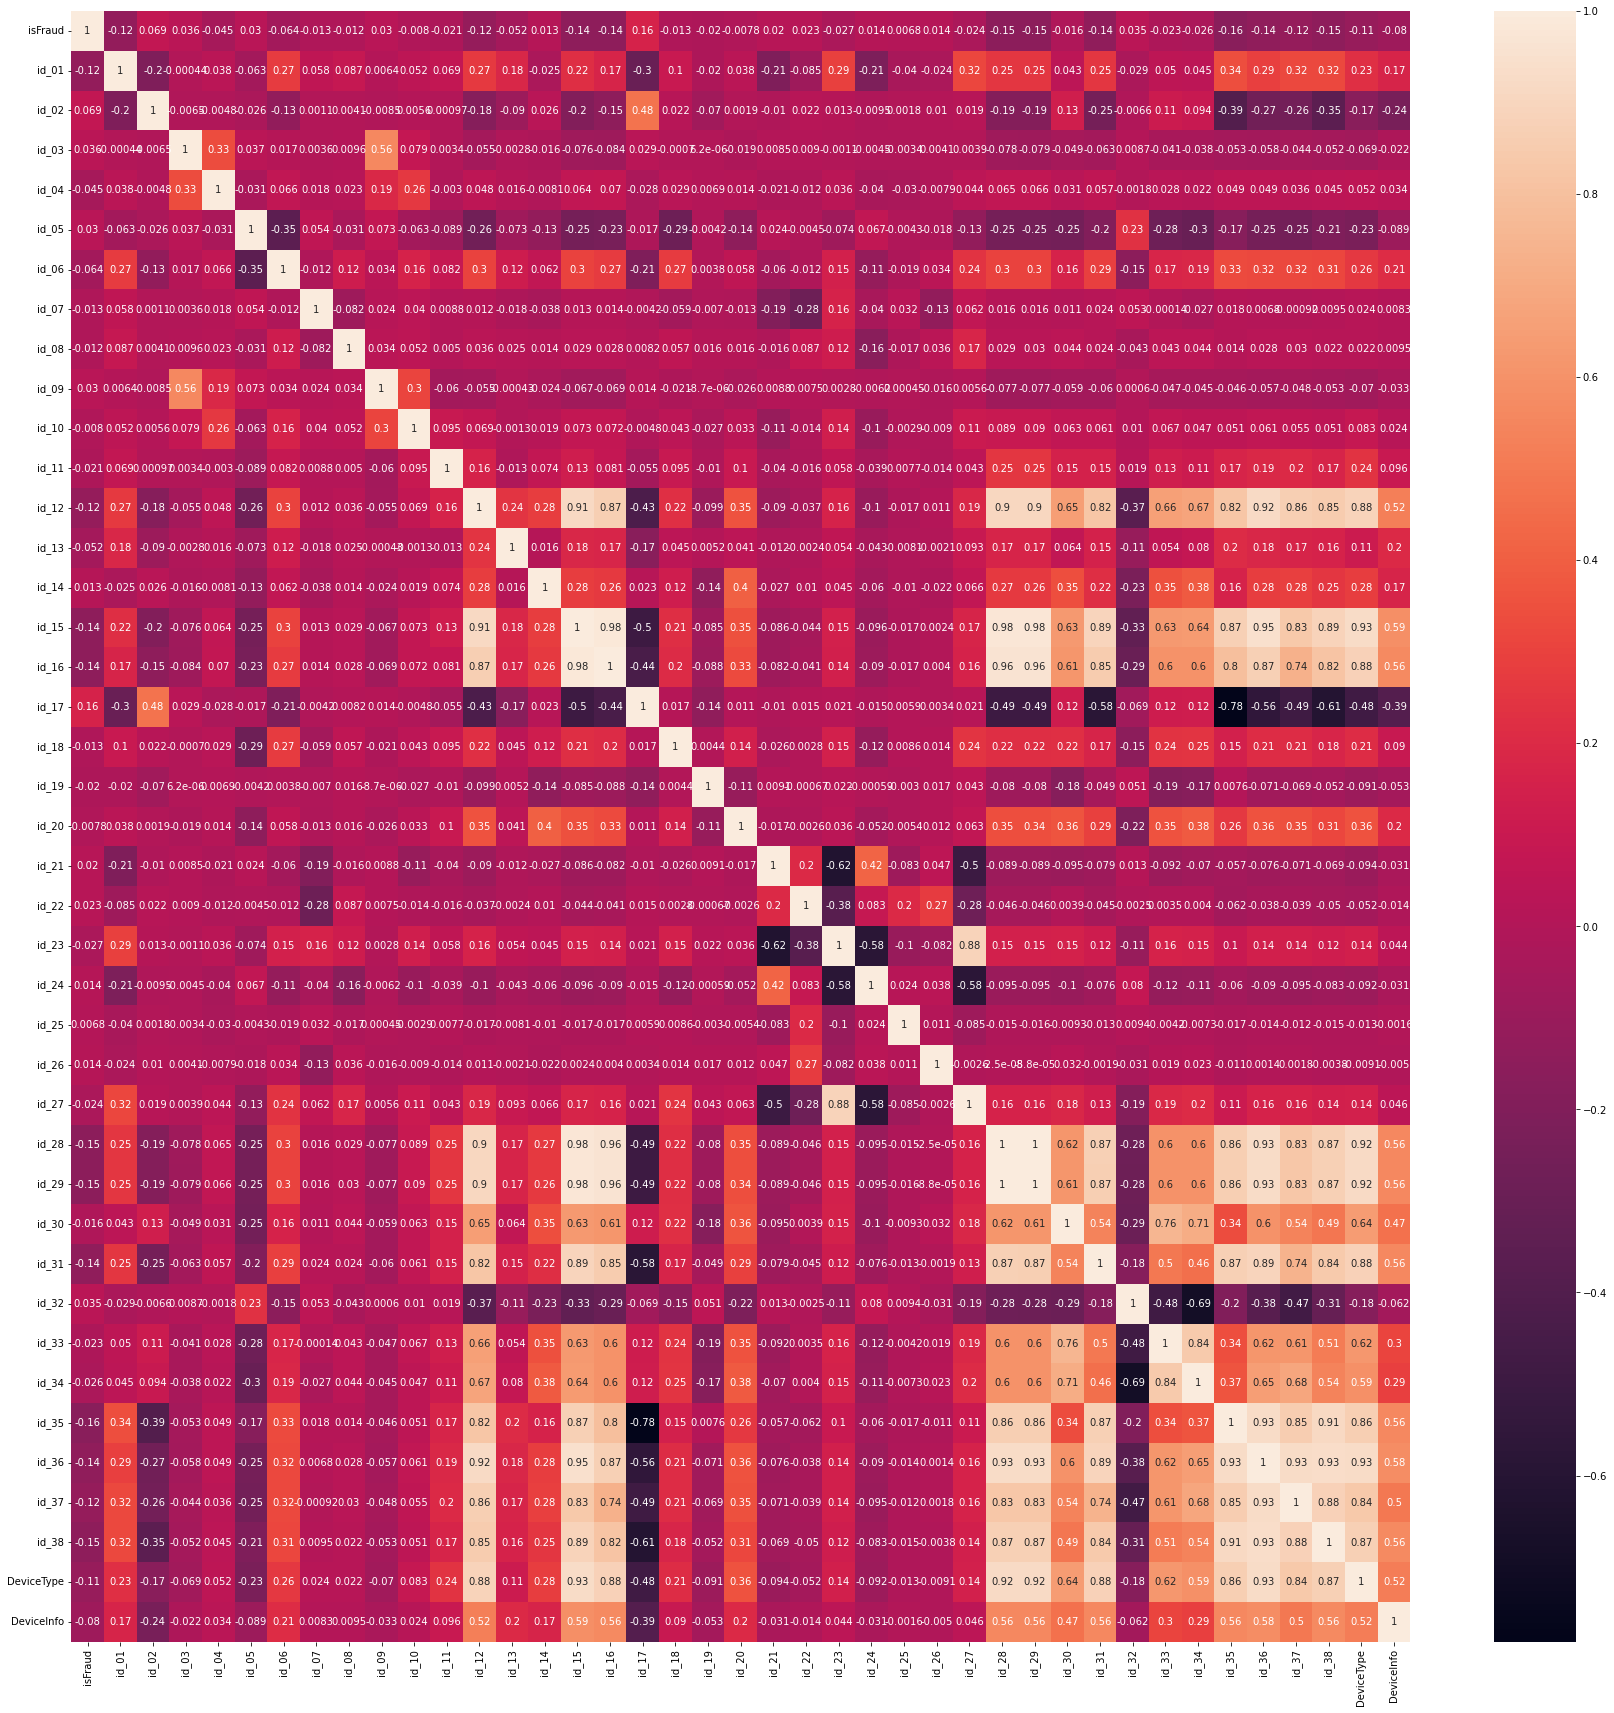

In [112]:
plt.figure(figsize=(30,30))
sns.heatmap(train_id_frd_fn.corr(), annot=True)
plt.show()

In [ ]:
# 차마 겁나서 이건 못돌리겠음...
# plt.figure(figsize=(100,100))
# sns.heatmap(train_v_frd_fn.corr(), annot=True)
# plt.show()

In [54]:
# NaN 처리 => mean, medain
train_encoded_fna_mean = train_encoded.fillna(train_encoded.mean(numeric_only=True))
train_encoded_fna_median = train_encoded.fillna(train_encoded.median())

/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [55]:
train_encoded_fna_mean.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,inf,59,60,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,inf,NaN,0.0,13.0,13.0,inf,inf,inf,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,47453.19140625,NaN,NaN,NaN,877.8887939453125,2239.911865234375,359.469390869140625,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,444.147125244140625,1078.3275146484375,686.9569091796875,NaN,NaN,NaN,NaN,NaN,NaN,385.13702392578125,765.98846435546875,536.302734375,38.437549591064453,133.208221435546875,71.107147216796875,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.390647888183594,201.657608032226562,153.520553588867188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.151641845703125,NaN,31.797275543212891,51.956645965576172,42.328224182128906,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,721.74188232421875,1375.78369140625,1014.622802734

In [56]:
resumetable(train_encoded_fna_mean)

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2.987000000000000e+06,2.987001000000000e+06,2.987002000000000e+06,19.170000000000002
1,isFraud,int8,0,2,0.000000000000000e+00,0.000000000000000e+00,0.000000000000000e+00,0.220000000000000
2,TransactionDT,int32,0,573349,8.640000000000000e+04,8.640100000000000e+04,8.646900000000000e+04,19.109999999999999
3,TransactionAmt,float16,0,8195,6.850000000000000e+01,2.900000000000000e+01,5.900000000000000e+01,8.100000000000000
4,ProductCD,int64,0,5,4.000000000000000e+00,4.000000000000000e+00,4.000000000000000e+00,1.280000000000000
5,card1,int16,0,13553,1.392600000000000e+04,2.755000000000000e+03,4.663000000000000e+03,9.970000000000001
6,card2,float16,8933,500,NaN,4.040000000000000e+02,4.900000000000000e+02,6.320000000000000
7,card3,float16,1565,114,1.500000000000000e+02,1.500000000000000e+02,1.500000000000000e+02,0.680000000000000
8,card4,int64,0,5,1.000000000000000e+00,2.000000000000000e+00,3.000000000000000e+00,1.110000000000000
9,card5,float16,4259,119,1.420000000000000e+02,1.020000000000000e+02,1.660000000000000e+02,2.660000000000000


In [53]:
train_encoded_fna_median.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,361.0,150.0,1,142.0,1,315.0,87.0,19.0,37.0,59,60,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,0.0,37.875,0.66650390625,13.0,13.0,0.0,0.0,0.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,0.0,100.0,2,52.0,-300.0,3,2,166.0,15.0,341.0,472.0,252.0,14.0,3,11.0,321.0,149.0,2,2,2,75,130,24.0,260,4,2,2,2,2,2,1786
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,8.0,37.0,16,60,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.

In [79]:
resumetable(train_encoded_fna_median)

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2987000.00000000000,2987001.00000000000,2987002.00000000000,19.170000000000002
1,isFraud,int8,0,2,0.00000000000,0.00000000000,0.00000000000,0.220000000000000
2,TransactionDT,int32,0,573349,86400.00000000000,86401.00000000000,86469.00000000000,19.109999999999999
3,TransactionAmt,float16,0,8195,68.50000000000,29.00000000000,59.00000000000,8.100000000000000
4,ProductCD,int64,0,5,4.00000000000,4.00000000000,4.00000000000,1.280000000000000
5,card1,int16,0,13553,13926.00000000000,2755.00000000000,4663.00000000000,9.970000000000001
6,card2,float16,0,500,361.00000000000,404.00000000000,490.00000000000,6.310000000000000
7,card3,float16,0,114,150.00000000000,150.00000000000,150.00000000000,0.680000000000000
8,card4,int64,0,5,1.00000000000,2.00000000000,3.00000000000,1.110000000000000
9,card5,float16,0,119,142.00000000000,102.00000000000,166.00000000000,2.650000000000000


In [51]:
# 우선 생으로 돌려보기
X_train = train_encoded_fna_mean.drop(columns=['isFraud'])
y_train = train_encoded_fna_mean[['isFraud']]

X_train_1 = train_encoded_fna_median.drop(columns=['isFraud'])
y_train_1 = train_encoded_fna_median[['isFraud']]

# setting parameters
random_state = np.random.RandomState(0xC0FFEE)
outliers_fraction = 0.0035
# Define seven outlier detection tools to be compared
classifiers = {
        'LOF': LOF(contamination=outliers_fraction),
        'HBOS': HBOS(contamination=outliers_fraction),
        'PCA': PCA(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
}

# model fitting 1
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X_train)
    y_pred = clf.labels_
    print(clf_name)
    print('accuracy : ',round(accuracy_score(y_train,y_pred),3))
    print('precision : ',round(precision_score(y_train,y_pred),3))
    print('recall : ',round(recall_score(y_train,y_pred),3))
    print('f1 : ',round(f1_score(y_train,y_pred),3))
    print('-------------------')
    
# model fitting 2
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X_train_1)
    y_pred_1 = clf.labels_
    print(clf_name)
    print('accuracy : ',round(accuracy_score(y_train_1,y_pred_1),3))
    print('precision : ',round(precision_score(y_train_1,y_pred_1),3))
    print('recall : ',round(recall_score(y_train_1,y_pred_1),3))
    print('f1 : ',round(f1_score(y_train_1,y_pred_1),3))
    print('-------------------')

/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN.

## rubish

In [ ]:
len(train_m_chk_frd_encoded[train_m_chk_frd_encoded['M4'] == 2])

In [ ]:
train_m_chk_frd_encoded.corr()

In [ ]:
# Fraud 중 상관관계 확인
list_obj_trans = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
train_m_chk_encoded = MultiColLabelEncoder().fit_transform(train_m_chk, columns=list_obj_trans)

plt.figure(figsize=(10,10))
sns.heatmap(train_m_chk_encoded.corr(), annot=True)
plt.show()

In [ ]:
# 전체 상관관계 확인
list_obj_trans = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
train_m_chk_encoded = MultiColLabelEncoder().fit_transform(train_m_chk, columns=list_obj_trans)

plt.figure(figsize=(10,10))
sns.heatmap(train_m_chk_encoded.corr(), annot=True)
plt.show()

In [ ]:
# NaN 
list_obj_trans = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
train_m_chk_encoded = MultiColLabelEncoder().fit_transform(train_m_chk, columns=list_obj_trans)

plt.figure(figsize=(10,10))
sns.heatmap(train_m_chk_encoded.corr(), annot=True)
plt.show()

In [ ]:
list_obj_trans = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
train_m_dropna_encoded = MultiColLabelEncoder().fit_transform(train_m_dropna, columns=list_obj_trans)

plt.figure(figsize=(10,10))
sns.heatmap(train_m_dropna_encoded.corr(), annot=True)
plt.show()

In [ ]:
len(train_m_chk_frd[train_m_chk_frd['M1'] == 'T'])

In [ ]:
len(train_m_chk_frd)

In [ ]:
len(train_m[train_m['M1'] == 'T'])

In [ ]:
train_m_chk_frd_encoded[train_m_chk_frd_encoded.columns[2]]

In [ ]:
for i in range(2,10):
    print(f'M{i} mean value:', train_m_chk_frd_encoded[train_m_chk_frd_encoded.columns[i]].mean())

In [ ]:
train.iloc[:,-7:-2].head(50)

In [ ]:
train['id_34'].value_counts()

In [ ]:
train[train['id_34'] == 'match_status:2'].iloc[:,-7:-2].head(20)

In [ ]:
train[train['id_34'] == 'match_status:-1'].head(100)

In [ ]:
train[train['id_34'] == 'match_status:0'].head(200)

In [ ]:
train[train['id_34'] == 'match_status:1'].head(100)

In [ ]:
# 연산을 위한 데이터타입 변환
train['TransactionAmt'] = train['TransactionAmt'].astype(float)

# 거래 금액 분위 확인
print(train['TransactionAmt'].quantile([.01, .025, .05, .1, .25, .5, .75, .9, .95, .975, .99]))

In [ ]:
# 거래 시간에 따른 분포 확인
train['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=500,
                                        title='TransactionDT distribution')
plt.show()

In [ ]:
# 거래 시간

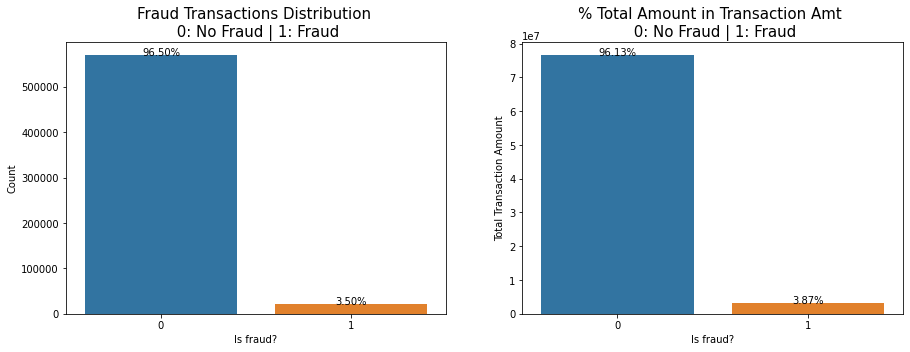

In [29]:
# 연산을 위한 데이터타입 변환
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
train['isFraud'] = train['isFraud'].astype(int)

total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()

# 시각화
plt.figure(figsize=(15,5))

# 거래 건수 기준 Fraud 비율 확인 
plt.subplot(121)
sp = sns.countplot(x='isFraud', data=train)  
sp.set_title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud", fontsize=15)
sp.set_xlabel("Is fraud?")
sp.set_ylabel('Count')
for i in sp.patches:
    height = i.get_height()
    sp.text(i.get_x()+i.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 

# 거래 금액 기준 Fraud 비율 확인 
perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()

plt.subplot(122)
sp1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
sp1.set_title("% Total Amount in Transaction Amt \n 0: No Fraud | 1: Fraud", fontsize=15)
sp1.set_xlabel("Is fraud?")
sp1.set_ylabel('Total Transaction Amount')
for i in sp1.patches:
    height = i.get_height()
    sp1.text(i.get_x()+i.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=10) 
    
plt.show()

- 거래 건수 및 금액 기준 약 3% 중,후반대로 Fraud 발생 ==> 크지 않은 비중

In [ ]:
train_rst_card = train_rst[5:11]
train_rst_card

In [ ]:
# multi columns encoding

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

class MultiColLabelEncoder:
    def __init__(self):
        self.encoder_dict = defaultdict(LabelEncoder)
        
    def fit_transform(self, X: pd.DataFrame, columns: list): # 컬럼명 리스트 기준으로 레이블인코딩
        if not isinstance(columns, list):
            columns = [columns]
        
        output = X.copy()
        output[columns] = X[columns].apply(lambda x: self.encoder_dict[x.name].fit_transform(x))
        
        return output
    
    def inverse_transform(self, X: pd.DataFrame, columns: list): # 인코딩 된 열 레이블 복구
        if not isinstance(columns, list):
            columns = [columns]
            
        if not all(key in self.encoder_dict for key in columns):
            raise KeyError(f'At least one of {columns} is not encoded before')
            
        output = X.copy()
        try:
            output[columns] = X[columns].apply(lambda x: self.encoder_dict[x.name].inverse_transform(x))
        except ValueError:
            print(f'Need assignment when do "fit_transform" function')
            raise
            
        return output

In [ ]:
list_obj_trans = list(df_trans_rst[df_trans_rst['dtypes'] == 'object']['Name'])

obj_to_int_trans = MultiColLabelEncoder().fit_transform(df_trans, columns=list_obj_trans)
obj_to_int_trans[list_obj_trans].head()
# obj_to_int_trans.head()

In [ ]:
df_trans[list_obj_trans].head()

In [ ]:
print(df_trans['ProductCD'].value_counts())
print(obj_to_int_trans['ProductCD'].value_counts())

In [ ]:
# df_train.corr()
# 의미 없는 것으로 확인